# Project 3: Secret Sharing
Author: James Bui

This notebook compares the runtimes of the computation of numbers using different privacy methods.

In [2]:
from phe import paillier
import random
import time
import numpy as np
import matplotlib.pyplot as plt

### Setting

Set the prime and bit lengths so that Shamir's secret sharing and Paillier have the same security level.

In [9]:
bits_length = 64

n_values = [2, 10, 100, 250, 500]

data = {}

prime = 10523145075623912869  # 64-bit prime

# Generate unique random integers for each n
data = {
    n: random.sample(range(1, 2*n + 1), n)
    for n in n_values
}
    
    

In [10]:
def time_function(func, *args, **kwargs):
    """
    Measures the runtime of a function.

    Parameters:
        func: The function to run
        *args: Positional arguments to pass to func
        **kwargs: Keyword arguments to pass to func

    Returns:
        result: The return value of func
        runtime: Time taken in seconds
    """
    start_time = time.perf_counter()
    result = func(*args, **kwargs)
    end_time = time.perf_counter()
    runtime = end_time - start_time
    return result, runtime

### No privacy protection

In [11]:
def average_with_no_protection(nums):
    return sum(nums) / len(nums)

In [17]:
no_protection_runtimes = []
no_protection_results = []

num_runs = 5  # Number of repeated runs per n

for n in n_values:
    runtimes = []
    results = []

    for _ in range(num_runs):
        result, runtime = time_function(average_with_no_protection, data[n])
        runtimes.append(runtime)
        results.append(result)

    avg_runtime = np.mean(runtimes)
    no_protection_runtimes.append(avg_runtime)
    no_protection_results.append(results[-1])

    print(f"n = {n}")
    print(f"  Average runtime: {avg_runtime:.6f} s")
    print(f"  Last result: {results[-1]}\n")

print("Average runtimes of no privacy protection:", no_protection_runtimes)
print("Results of no privacy protection:", no_protection_results)


n = 2
  Average runtime: 0.000000 s
  Last result: 2.5

n = 10
  Average runtime: 0.000000 s
  Last result: 10.7

n = 100
  Average runtime: 0.000001 s
  Last result: 100.01

n = 250
  Average runtime: 0.000001 s
  Last result: 247.548

n = 500
  Average runtime: 0.000002 s
  Last result: 504.212

Average runtimes of no privacy protection: [np.float64(4.393979907035828e-07), np.float64(3.0561350286006925e-07), np.float64(5.558016709983349e-07), np.float64(1.0985997505486011e-06), np.float64(2.0944047719240188e-06)]
Results of no privacy protection: [2.5, 10.7, 100.01, 247.548, 504.212]


### The additively homomorphic *Paillier* encryption scheme 

In [13]:
import numpy as np
from phe import paillier

def initialize_keys(bits_length=2048):
    public_key, private_key = paillier.generate_paillier_keypair(n_length=bits_length)
    return public_key, private_key

def encrypt_data(public_key, data):
    return [public_key.encrypt(x) for x in data]

def add_encrypted_data(encrypted_data):
    return sum(encrypted_data)

def decrypt_data(private_key, encrypted_sum):
    return private_key.decrypt(encrypted_sum)

def perform_encrypted_addition(public_key, private_key, nums):
    # Encrypt
    encrypted_values = encrypt_data(public_key, nums)
    
    # Add encrypted numbers
    encrypted_sum = add_encrypted_data(encrypted_values)
    
    # Decrypt sum
    decrypted_sum = decrypt_data(private_key, encrypted_sum)
    
    avg = decrypted_sum / len(nums)
    return avg

# --- Separate timing for encryption, computation, and decryption ---

paillier_enc_times = []
paillier_add_times = []
paillier_dec_times = []
paillier_results = []

public_key, private_key = initialize_keys(bits_length=bits_length)
num_runs = 5

for n in n_values:
    enc_times, add_times, dec_times = [], [], []
    results = []

    for _ in range(num_runs):
        nums = data[n]

        # Encryption timing
        encrypted_values, enc_time = time_function(encrypt_data, public_key, nums)
        
        # Addition timing
        encrypted_sum, add_time = time_function(add_encrypted_data, encrypted_values)
        
        # Decryption timing
        decrypted_sum, dec_time = time_function(decrypt_data, private_key, encrypted_sum)
        
        avg = decrypted_sum / len(nums)
        results.append(avg)

        enc_times.append(enc_time)
        add_times.append(add_time)
        dec_times.append(dec_time)

    # Store average runtimes per step
    paillier_enc_times.append(np.mean(enc_times))
    paillier_add_times.append(np.mean(add_times))
    paillier_dec_times.append(np.mean(dec_times))
    paillier_results.append(results[-1])

    print(f"n = {n}")
    print(f"  Avg encryption time: {np.mean(enc_times):.6f} s")
    print(f"  Avg addition time:   {np.mean(add_times):.6f} s")
    print(f"  Avg decryption time: {np.mean(dec_times):.6f} s")
    print(f"  Last result: {results[-1]}\n")

print("Paillier encryption times:", paillier_enc_times)
print("Paillier addition times:", paillier_add_times)
print("Paillier decryption times:", paillier_dec_times)
print("Paillier results:", paillier_results)


n = 2
  Avg encryption time: 0.000067 s
  Avg addition time:   0.000008 s
  Avg decryption time: 0.000011 s
  Last result: 2.5

n = 10
  Avg encryption time: 0.000179 s
  Avg addition time:   0.000013 s
  Avg decryption time: 0.000011 s
  Last result: 10.7

n = 100
  Avg encryption time: 0.001582 s
  Avg addition time:   0.000067 s
  Avg decryption time: 0.000011 s
  Last result: 100.01

n = 250
  Avg encryption time: 0.003817 s
  Avg addition time:   0.000157 s
  Avg decryption time: 0.000011 s
  Last result: 247.548

n = 500
  Avg encryption time: 0.007608 s
  Avg addition time:   0.000305 s
  Avg decryption time: 0.000012 s
  Last result: 504.212

Paillier encryption times: [np.float64(6.744801066815853e-05), np.float64(0.00017855758778750896), np.float64(0.0015822354122065007), np.float64(0.0038168261758983134), np.float64(0.007607603596989065)]
Paillier addition times: [np.float64(8.062005508691073e-06), np.float64(1.2791005428880452e-05), np.float64(6.66070031002164e-05), np.floa

### Shamir's secret sharing

In [14]:
# Evaluate a polynomial at a given x modulo a prime
def evaluate_polynomial_mod(x, coefficients, prime):
    result = 0
    power = 1
    for coeff in coefficients:
        result = (result + coeff * power) % prime
        power = (power * x) % prime
    return result % prime

def evaluate_polynomial_mod(x, coefficients, prime):
    return sum((coeff * pow(x, i, prime)) % prime for i, coeff in enumerate(coefficients)) % prime

# Generate shares for a secret modulo prime
def generate_shares_mod(secret, num_shares, threshold, prime):
    coefficients = [secret] + [random.randint(1, 1000) for _ in range(threshold - 1)]
    shares = [(x, evaluate_polynomial_mod(x, coefficients, prime)) for x in range(1, num_shares + 1)]
    return shares

# Reconstruct secret from shares using Lagrange interpolation modulo prime
def reconstruct_secret_mod(x_points, y_points, prime):
    num_points = len(x_points)
    secret = 0
    for i in range(num_points):
        numerator = 1
        denominator = 1
        for j in range(num_points):
            if i != j:
                numerator = (numerator * (-x_points[j])) % prime
                denominator = (denominator * (x_points[i] - x_points[j])) % prime
        inv_denominator = pow(denominator, -1, prime)
        secret = (secret + y_points[i] * numerator * inv_denominator) % prime
    return secret

# Phase 1: Encryption (Share Generation)
def encryption_phase(secrets, num_shares, threshold, prime):
    num_secrets = len(secrets)
    
    # Generate shares for each secret
    all_shares = []
    for secret in secrets:
        shares = generate_shares_mod(secret, num_shares, threshold, prime)
        all_shares.append(shares)
    
    return all_shares

# Phase 2: Calculation (Share Aggregation)
def calculation_phase(all_shares, num_shares, num_secrets, prime):
    # Sum the shares for each party (point-wise)
    summed_shares = []
    for i in range(num_shares):
        x = all_shares[0][i][0]  # same x for all secrets
        y_sum = sum(all_shares[s][i][1] for s in range(num_secrets)) % prime
        summed_shares.append((x, y_sum))
    
    return summed_shares

# Phase 3: Decryption (Secret Reconstruction)
def decryption_phase(summed_shares, threshold, prime, num_secrets):
    # Reconstruct the sum of secrets using first `threshold` shares
    x_points = [summed_shares[i][0] for i in range(threshold)]
    y_points = [summed_shares[i][1] for i in range(threshold)]
    total_sum = reconstruct_secret_mod(x_points, y_points, prime)
    
    # Compute the average
    average = total_sum / num_secrets
    return average

# Compute the average of multiple secrets using Shamir's Secret Sharing
def shamir_secret_sharing(secrets, num_shares, threshold, prime):
    num_secrets = len(secrets)
    
    # Phase 1: Encryption
    all_shares, encryption_time = time_function(encryption_phase, secrets, num_shares, threshold, prime)
    
    # Phase 2: Calculation
    summed_shares, calculation_time = time_function(calculation_phase, all_shares, num_shares, num_secrets, prime)
    
    # Phase 3: Decryption
    average, decryption_time = time_function(decryption_phase, summed_shares, threshold, prime, num_secrets)
    
    return average, encryption_time, calculation_time, decryption_time


shamir_enc_times = []
shamir_calc_times = []
shamir_dec_times = []
shamir_results = []

num_runs = 5

for n in n_values:
    enc_times, calc_times, dec_times = [], [], []
    results = []
    
    for _ in range(num_runs):
        nums = data[n]
        
        # Run Shamir Secret Sharing with timing
        avg, enc_time, calc_time, dec_time = shamir_secret_sharing(nums, n, n // 2 + 1, prime)
        
        results.append(avg)
        enc_times.append(enc_time)
        calc_times.append(calc_time)
        dec_times.append(dec_time)
    
    # Store average runtimes per step
    shamir_enc_times.append(np.mean(enc_times))
    shamir_calc_times.append(np.mean(calc_times))
    shamir_dec_times.append(np.mean(dec_times))
    shamir_results.append(results[-1])
    
    print(f"n = {n}")
    print(f"  Avg encryption time:   {np.mean(enc_times):.6f} s")
    print(f"  Avg calculation time:  {np.mean(calc_times):.6f} s")
    print(f"  Avg decryption time:   {np.mean(dec_times):.6f} s")
    print(f"  Last result: {results[-1]}\n")

print("Shamir encryption times:", shamir_enc_times)
print("Shamir calculation times:", shamir_calc_times)
print("Shamir decryption times:", shamir_dec_times)
print("Shamir results:", shamir_results)

n = 2
  Avg encryption time:   0.000014 s
  Avg calculation time:  0.000004 s
  Avg decryption time:   0.000007 s
  Last result: 2.5

n = 10
  Avg encryption time:   0.000132 s
  Avg calculation time:  0.000010 s
  Avg decryption time:   0.000013 s
  Last result: 10.7

n = 100
  Avg encryption time:   0.154773 s
  Avg calculation time:  0.000524 s
  Avg decryption time:   0.000552 s
  Last result: 100.01

n = 250
  Avg encryption time:   3.500972 s
  Avg calculation time:  0.003843 s
  Avg decryption time:   0.003049 s
  Last result: 247.548

n = 500
  Avg encryption time:   34.004624 s
  Avg calculation time:  0.019029 s
  Avg decryption time:   0.011524 s
  Last result: 504.212

Shamir encryption times: [np.float64(1.4388398267328738e-05), np.float64(0.00013161560054868459), np.float64(0.15477269779657946), np.float64(3.5009721765876747), np.float64(34.0046242239885)]
Shamir calculation times: [np.float64(3.572762943804264e-06), np.float64(1.0060612112283707e-05), np.float64(0.000524

Plotting the results

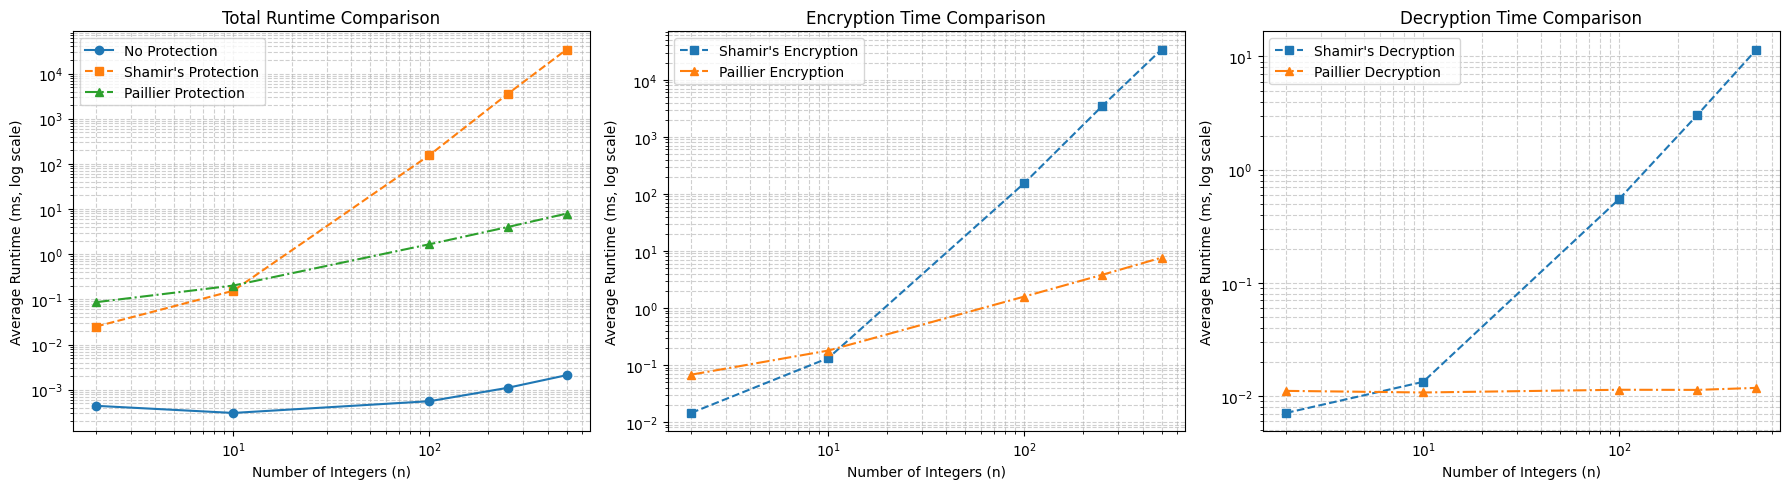

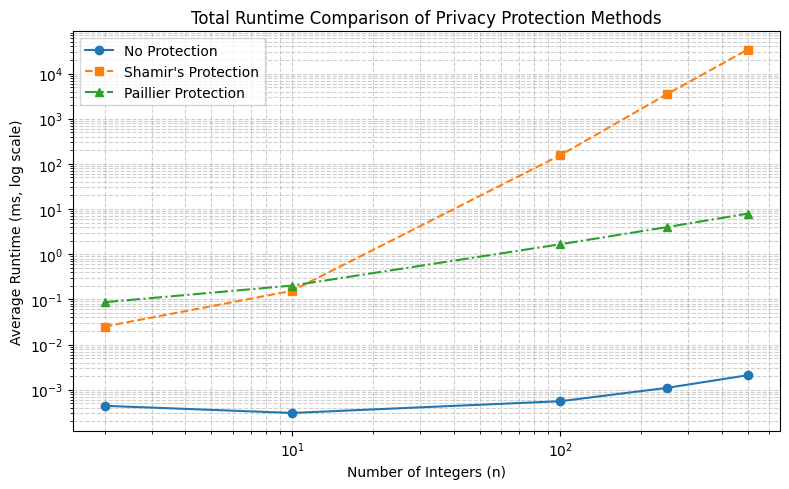

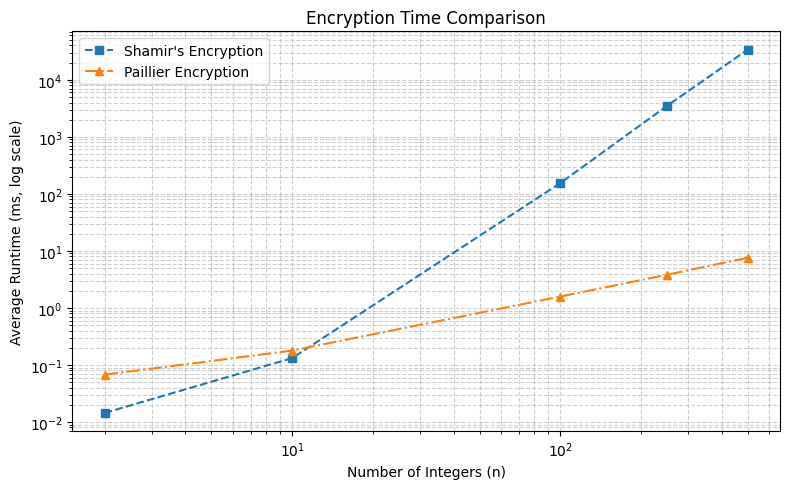

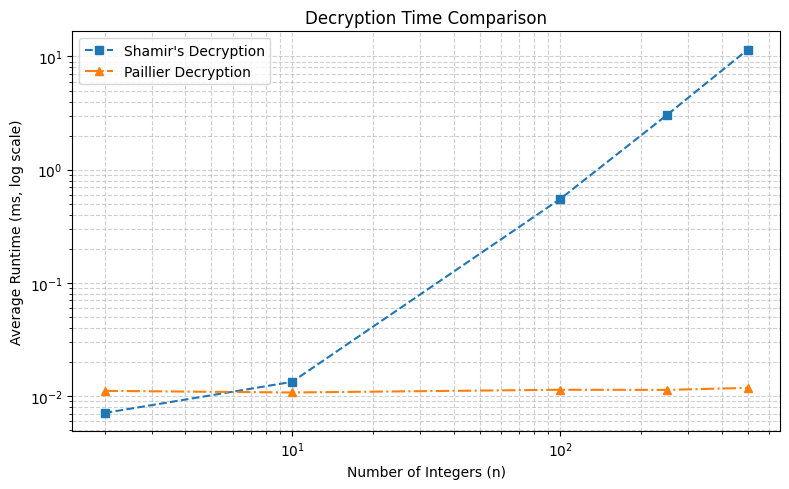

In [18]:
# Calculate total times
shamir_total_times = [enc + calc + dec for enc, calc, dec in 
                      zip(shamir_enc_times, shamir_calc_times, shamir_dec_times)]
paillier_total_times = [enc + add + dec for enc, add, dec in 
                        zip(paillier_enc_times, paillier_add_times, paillier_dec_times)]

# Convert runtimes to milliseconds
no_protection_runtimes_ms = [rt * 1000 for rt in no_protection_runtimes]
shamir_total_ms = [rt * 1000 for rt in shamir_total_times]
paillier_total_ms = [rt * 1000 for rt in paillier_total_times]

shamir_enc_ms = [rt * 1000 for rt in shamir_enc_times]
shamir_dec_ms = [rt * 1000 for rt in shamir_dec_times]
paillier_enc_ms = [rt * 1000 for rt in paillier_enc_times]
paillier_dec_ms = [rt * 1000 for rt in paillier_dec_times]

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Total Time Comparison (All 3 methods)
axes[0].plot(n_values, no_protection_runtimes_ms, marker='o', linestyle='-', label='No Protection')
axes[0].plot(n_values, shamir_total_ms, marker='s', linestyle='--', label="Shamir's Protection")
axes[0].plot(n_values, paillier_total_ms, marker='^', linestyle='-.', label='Paillier Protection')

axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_xlabel('Number of Integers (n)')
axes[0].set_ylabel('Average Runtime (ms, log scale)')
axes[0].set_title('Total Runtime Comparison')
axes[0].grid(True, which='both', linestyle='--', alpha=0.6)
axes[0].legend()

# Plot 2: Encryption Time Comparison (Shamir vs Paillier)
axes[1].plot(n_values, shamir_enc_ms, marker='s', linestyle='--', label="Shamir's Encryption")
axes[1].plot(n_values, paillier_enc_ms, marker='^', linestyle='-.', label='Paillier Encryption')

axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Number of Integers (n)')
axes[1].set_ylabel('Average Runtime (ms, log scale)')
axes[1].set_title('Encryption Time Comparison')
axes[1].grid(True, which='both', linestyle='--', alpha=0.6)
axes[1].legend()

# Plot 3: Decryption Time Comparison (Shamir vs Paillier)
axes[2].plot(n_values, shamir_dec_ms, marker='s', linestyle='--', label="Shamir's Decryption")
axes[2].plot(n_values, paillier_dec_ms, marker='^', linestyle='-.', label='Paillier Decryption')

axes[2].set_yscale('log')
axes[2].set_xscale('log')
axes[2].set_xlabel('Number of Integers (n)')
axes[2].set_ylabel('Average Runtime (ms, log scale)')
axes[2].set_title('Decryption Time Comparison')
axes[2].grid(True, which='both', linestyle='--', alpha=0.6)
axes[2].legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig("comparison_three_plots.png", dpi=300)
plt.show()

# Also create individual plots if needed
# Plot 1: Total Time (separate file)
plt.figure(figsize=(8, 5))
plt.plot(n_values, no_protection_runtimes_ms, marker='o', linestyle='-', label='No Protection')
plt.plot(n_values, shamir_total_ms, marker='s', linestyle='--', label="Shamir's Protection")
plt.plot(n_values, paillier_total_ms, marker='^', linestyle='-.', label='Paillier Protection')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Integers (n)')
plt.ylabel('Average Runtime (ms, log scale)')
plt.title('Total Runtime Comparison of Privacy Protection Methods')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("comparison_total_time.png", dpi=300)
plt.show()

# Plot 2: Encryption Time (separate file)
plt.figure(figsize=(8, 5))
plt.plot(n_values, shamir_enc_ms, marker='s', linestyle='--', label="Shamir's Encryption")
plt.plot(n_values, paillier_enc_ms, marker='^', linestyle='-.', label='Paillier Encryption')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Integers (n)')
plt.ylabel('Average Runtime (ms, log scale)')
plt.title('Encryption Time Comparison')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("comparison_encryption_time.png", dpi=300)
plt.show()

# Plot 3: Decryption Time (separate file)
plt.figure(figsize=(8, 5))
plt.plot(n_values, shamir_dec_ms, marker='s', linestyle='--', label="Shamir's Decryption")
plt.plot(n_values, paillier_dec_ms, marker='^', linestyle='-.', label='Paillier Decryption')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Integers (n)')
plt.ylabel('Average Runtime (ms, log scale)')
plt.title('Decryption Time Comparison')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("comparison_decryption_time.png", dpi=300)
plt.show()